# TooBike

## Overview
I modifying and analysing a bikeshare model for Brisbane City Council(BCC). 

### Brisbane Bikeshare 
Brisbane City Council is interested in developing a bikeshare system.  BCC's well-maintained bike trails and bikelanes on main streets are popular with residents and may also be popular with tourists.

BCC wants to explore possible bike share scenarios which can accomadate both tourists and residents.  For the inital *TooBike* trial, the council's financial advisors have agreed to fund **3 locations** and **45 bikes**.  


In [11]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim library
from modsim import *

# set the random number generator
np.random.seed(0)

In [21]:
def make_state(kwargs):
    """ Define the system's stations and their initial distribution of bikes.
    
        kwargs: Initial system state is passed to the function in the parameter.
    """   
    state = State(kwargs)
    return state


def run_simulation(state, trips, num_steps):
    """ Simulate the given number of time steps.
    
        state: bikeshare State
        trips: provides the probability and the function for each potential bike trip.
        num_steps: number of time steps
    """
    for i in range(num_steps):
        step(state, trips)
        
    return state

def step(state, trips):
    """ simulate different bike system configurations
     
      state: bikeshare State 
      trips: list of tuples: [(p1, bike_to_TB1_TB2),...]. Each tuple in the list provides the probability and 
              the function to be called for each potential bike trip. 
    """
    state.clock += 1

    for p, func in trips:
        if flip(p):
            func(state)  
            
    if state.t_first_empty == -1:
        check_first_empty(state)
        
    return


def check_first_empty(state):
    """ checks the status of the model's bike stations
        
        state: bikeshare State
    """
    if  state.TB1_empty + state.TB2_empty + state.TB3_empty > 0: 
        state.t_first_empty = state.clock 
        

def bike_to_TB1_TB2(state):
    """Move one bike from TB1 to TB2.
    
       state: bikeshare State object
    """
    if state.TB1 == 0:
        state.TB1_empty += 1
        return
    
    state.TB1 -= 1
    state.TB2 += 1
        
    
def bike_to_TB1_TB3(state):
    """Move one bike from TB1 to TB3.
    
       state: bikeshare State object
    """
    if state.TB1 == 0:
        state.TB1_empty += 1
        return
    
    state.TB1 -= 1
    state.TB3 += 1 
    
def bike_to_TB2_TB1(state):
    """Move one bike from TB2 to TB1.
    
       state: bikeshare State object
    """
    if state.TB2 == 0:
        state.TB2_empty += 1
        return
    
    state.TB2 -= 1
    state.TB1 += 1 
        
def bike_to_TB2_TB3(state):
    """Move one bike from TB2 to TB3.
    
       state: bikeshare State object
    """
    if state.TB2 == 0:
        state.TB2_empty += 1
        return
    state.TB2 -= 1
    state.TB3 += 1 
    
def bike_to_TB3_TB1(state):
    """Move one bike from TB3 to TB1.
    
       state: bikeshare State object
    """
    if state.TB3 == 0:
        state.TB3_empty += 1
        return
    state.TB3 -= 1
    state.TB1 += 1 
    
    
def bike_to_TB3_TB2(state):
    """Move one bike from TB3 to TB2.
    
       state: bikeshare State object
    """
    if state.TB3 == 0:
        state.TB3_empty += 1
        return
    state.TB3 -= 1
    state.TB2 += 1 
    
# Initial Bike system: 3 sites, 15 bikes each 
bike_system = {'clock':0, 't_first_empty':-1, 
               'resultsTB1':TimeSeries(),
               'resultsTB2':TimeSeries(),
               'resultsTB3':TimeSeries(),
               'TB1':15,'TB2':15,'TB3':15,
               'TB1_empty':0,'TB2_empty':0,'TB3_empty':0}

#  Trips list to include a tuple for each possible bike trip.      
trips = [(0.3, bike_to_TB1_TB2),(0.3, bike_to_TB1_TB3),
         (0.3, bike_to_TB2_TB1),(0.3, bike_to_TB2_TB3),
         (0.3, bike_to_TB3_TB1),(0.3, bike_to_TB3_TB2)]


[(0.3, <function __main__.bike_to_TB1_TB2(state)>),
 (0.3, <function __main__.bike_to_TB1_TB3(state)>),
 (0.3, <function __main__.bike_to_TB2_TB1(state)>),
 (0.3, <function __main__.bike_to_TB2_TB3(state)>),
 (0.3, <function __main__.bike_to_TB3_TB1(state)>),
 (0.3, <function __main__.bike_to_TB3_TB2(state)>)]

### Run simulation
I created a bikeshare model with 3 locations, let's take it for a ride and checkout some initial metrics. 

In [22]:
num_steps = 60
state = make_state(bike_system)


,values
clock,0
t_first_empty,-1
resultsTB1,"TimeSeries([], dtype: float64)"
resultsTB2,"TimeSeries([], dtype: float64)"
resultsTB3,"TimeSeries([], dtype: float64)"
TB1,15
TB2,15
TB3,15
TB1_empty,0
TB2_empty,0


In [23]:
state = run_simulation(state, trips, num_steps)

,values
clock,60
t_first_empty,-1
resultsTB1,"TimeSeries([], dtype: float64)"
resultsTB2,"TimeSeries([], dtype: float64)"
resultsTB3,"TimeSeries([], dtype: float64)"
TB1,13
TB2,11
TB3,21
TB1_empty,0
TB2_empty,0


# Bike usage - 24 hours 

Now let's run multiple simulations and plot the number of bikes at each bike station at the end of each hour over a 24 hour period.  We're trying to see how our inital 0.3 probabilites for all three bikestations works out.


In [24]:
# Model a 24 hour period: 24 simulations, each 60 minutes long
def run_simulation_plot(state, trips, num_steps, num_runs):
    """ Runs num_runs simulations of num_steps each. Records results in state variables
        after each run.
    
    state: bikeshare State object
    trips: List of tuples.  Each tuple in the list provides the 
           probability and function for each potential bike trip 
    num_steps: number of time steps, duration of each run
    num_runs: number of simulations to run
    """
    resultsTB1 = TimeSeries()
    resultsTB2 = TimeSeries()
    resultsTB3 = TimeSeries()
    resultsTB1[0]=15
    resultsTB2[0]=15
    resultsTB3[0]=15
    
    for i in range(1,num_runs+1):
        state = run_simulation(state, trips, num_steps)
        resultsTB1[i] = state.TB1 
        resultsTB2[i] = state.TB2 
        resultsTB3[i] = state.TB3
        
    plot(resultsTB1, label='TB1')
    plot(resultsTB2, label='TB2')
    plot(resultsTB3, label='TB3')
    decorate(title='TCC Bikeshare: Number of Bikes at each location/hour',loc='upper left' ,
             xlabel='Simulation over 24 hours', 
             ylabel='Number of bikes')
    
    
 

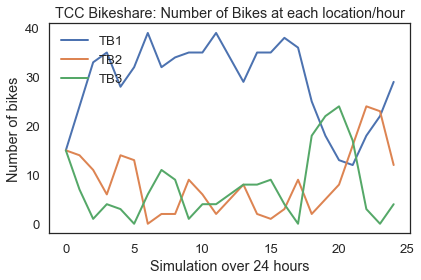

In [25]:
# Model a 24 hour period, 24 runs, each run has 60 steps

num_runs = 24  
num_steps = 60

# Create state object. 
state = make_state(bike_system)

run_simulation_plot(state, trips, num_steps, num_runs)

## Plot *Unhappy Customers* over a 24 hour period 

Now let's run a 24 hour simulation: record the number of unhappy customers at each bike station at the end of each hour over the 24 hour period.


In [26]:
# Model a 24 hour period: 24 simulations, each 60 minutes long

def run_simulation_plot_unhappy(state, trips, num_steps, num_runs):
    """ Runs num_runs simulations of num_steps each. Records results in state variables
        after each run.
    
    state: bikeshare State object
    trips: List of tuples.  Each tuple in the list provides the 
           probability and function for each potential bike trip 
    num_steps: number of time steps, duration of each run
    num_runs: number of simulations to run
    """
    sweepTB1 = SweepSeries()
    sweepTB2 = SweepSeries()
    sweepTB3 = SweepSeries()
    firstempty= SweepSeries()
    
    for i in range(1,num_runs+1):  
        bike_system = {'clock':0, 't_first_empty':-1, 
               'resultsTB1':TimeSeries(),
               'resultsTB2':TimeSeries(),
               'resultsTB3':TimeSeries(),
               'TB1':15,'TB2':15,'TB3':15,
               'TB1_empty':0,'TB2_empty':0,'TB3_empty':0}    
        
        state= make_state(bike_system)
         
        state = run_simulation(state, trips, num_steps)
        sweepTB1[i] = state.TB1_empty
        sweepTB2[i] = state.TB2_empty
        sweepTB3[i] = state.TB3_empty
        firstempty[i] = state.t_first_empty
        
    a=max(sweepTB1)
    b=max(sweepTB2)
    c=max(sweepTB3)
    
    for j in range (1,num_runs+1):
        if firstempty[j]!=-1:
            first=j
            break
             
    plot(sweepTB1, label='TB1 Unhappy:%a' %a)
    plot(sweepTB2, label='TB2 Unhappy:%a' %b)
    plot(sweepTB3, label='TB3 Unhappy:%a' %c)
        
    decorate(title='TCC Bikeshare 1st Unhappy:Hour%a' %first,loc='upper right',
             xlabel='Time Step (Hours)', 
             ylabel='Number of Unhappy Customers')
    
    

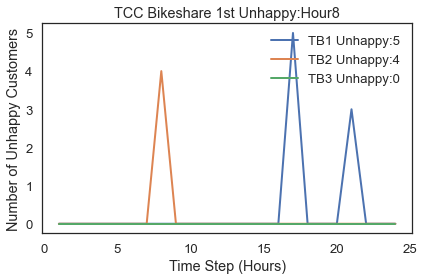

In [27]:
# Model a 24 hour period: 24 simulations, each 60 minutes long
num_runs = 24  
num_steps = 60

# Create state object. 
state = make_state(bike_system)

run_simulation_plot_unhappy(state, trips, num_steps, num_runs)

Notebook adapted from: *Modeling and Simulation in Python* by Allen B. Downey